In [47]:
# Reinforcment Learning with Foirier/Polynomial State Weighted Q Basis for Homogeus Multi Component Maitenance
# By Joseph Wittrock

# Enviroment/Training code adapted from:
# https://pytorch.org/rl/stable/tutorials/torchrl_envs.html
# https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

# The enviroment is composed of n components with m condition states. Each component degrades each step according to its degredation transition matrix. 
# The actions to the enviroment are 0 for do nothing, or 1 for repair.
# Only k components can be repaired at a time, and the repair cost is proportional to the number of components repaired.
# If a component is in a failed state, it will have a failure cost no matter what action is taken. (Though I want to change how this works for multiperiod adaptation)
# The goal is to maximize the reward over a fixed number of steps, reward is negative for repair costs and failure costs.

# The enviroment is written using TorchRL and TensorDict for efficient paralell computation on a cuda enabled GPU.

# The state space is reduced by considering the distrobution of the components in each condition state, rather than the condition state of each component.
# This condenses the state space to m states.

# To generalize the action space we search for an "equitable" policy. i.e. a component in worse condition is always repaired before a component in better condition.
# This reduces the action space to k actions.

# For large values of m, a traditional deep Q network would not generalize well, as there are too many output neurons.
# Instead, we use a basis of continuous valued functions over [0,1], and map the action space to i \mapsto i/k for i in [0,k]. 
# Note when i=0, no components are repaired, and when i=k, all components are repaired, so there are k+1 actions in total.

# The degrees of approximation determine the output nodes for the neural network, then the output is dot producted with the basis functions evaluated at the precalculated action domain points.
# This allows for scale free computation for increasing values of the repair constraint.

In [48]:
from typing import Optional

from matplotlib import pyplot as plt # for plotting
import numpy as np # for cpu based computation
import torch # for efficient (gpu) computation and automatic differentiation
from tqdm import tqdm # for progress bars
from tensordict import TensorDict, TensorDictBase # for handling dictionaries of tensors in a pytorch friendly way, e.g. for batched data
from torch import nn # for neural networks
import torch.optim as optim # for optimizers
import torch.nn.functional as F # for activation functions
from torch.utils.tensorboard import SummaryWriter # for logging to tensorboard


# TorchRL
from torchrl.data import BoundedTensorSpec, CompositeSpec, UnboundedContinuousTensorSpec # for defining the shape and type of data [Legacy]
from torchrl.data import Bounded, Composite, Unbounded # for defining the shape and type of data
from torchrl.envs import (
    CatTensors, # Concatenate tensors
    EnvBase, # Tensordict based env
    Transform, # Transform for envs
)
from torchrl.envs.transforms.transforms import _apply_to_composite # for applying a transform to a composite spec
from torchrl.envs.utils import check_env_specs, step_mdp # for checking env specs and stepping through an MDP

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # enable cuda if available 
print(f"Using device: {device}")
torch.set_default_device(device)

Using device: cuda


In [49]:
######################
#                    #
#   HYPERPARAMETERS  #
#                    #
######################

# Environment parameters
N_COMPONENTS = 1000 # number of components in each enviroment
MAX_REPAIR_CONSTRAINT = 50 # Maximum number of components that can be repaired in a single step
EPISODE_LENGTH = 128 # number of steps in each episode
STEP_BATCH_SIZE = 128 # number of environments to be executed in paralell
# - Cost parameters
# REPAIR_COST = 10.0 # cost per repair action taken each step
# FAILURE_COST = 20.0 # cost per maximum state (failed state) component each step
REWARD_BLEND = 0.75 # weight for blending orm costs and utility

# Optimization parameters
OPTIMIZATION_BATCH_SIZE = 64 * EPISODE_LENGTH # number of transitions to be used used in each optimization batch
BUFFER_SIZE = 1 * STEP_BATCH_SIZE * EPISODE_LENGTH # number of transitions to be stored in the memory replay buffer
OPTIMIZATION_PASSES = 1 # number of optimization passes to be made in each step
GAMMA = 0.98 # reward discount factor \in [0, 1]
TAU = 1e-2 # soft target network learning rate. \in [0, 1]
LR = 5e-3 # learning rate for policy network. \in [0, 1]
N_EPISODES = 50
EPOCHS = N_EPISODES * EPISODE_LENGTH  # number of epochs to train the policy network
# - Entropy parameters
ENTROPY_START = 0.5 # initial entropy value for random actions
ENTROPY_END = 0.1  # entropy value for random actions
ENTROPY_DECAY = 1_000  # entropy decay rate (I should make this exponential isntead of polynomial)
# - Agent Network parameters
BASIS =   "polynomial" # "fourier" #
N_DEEP_NODES = 32 # number of nodes in the deep network
DEGREE_APPROXIMATION = 3 # basis elements to be generated for action value approximation



In [50]:
###### Generate Other Parameters ######

# evaluate basis functions at every relevant action
# a = k / MAX_REPAIR_CONSTRAINT \in [0, 1] 
# for k \in { 0, 1, 2, ...,  MAX_REPAIR_CONSTRAINT }
basis_switch = { 
    "polynomial": torch.tensor([
        [ (n / MAX_REPAIR_CONSTRAINT )**k for n in range(MAX_REPAIR_CONSTRAINT + 1) ] 
        for k in range(DEGREE_APPROXIMATION)
    ], dtype=torch.float32),
    "fourier": torch.tensor([
        [np.cos(1 * np.pi * k * n / MAX_REPAIR_CONSTRAINT) for n in range(MAX_REPAIR_CONSTRAINT + 1)]
        for k in range(DEGREE_APPROXIMATION)
    ], dtype=torch.float32),
    }
basis = basis_switch[ BASIS ]


def get_basis(degree: int, max_repair_constraint: int, basis_type: str = "polynomial") -> torch.Tensor:
    if basis_type == "polynomial":
        return torch.tensor([
            [ (n / max_repair_constraint )**k for n in range(max_repair_constraint + 1) ] 
            for k in range(degree)
        ], dtype=torch.float32)
    elif basis_type == "fourier":
        return torch.tensor([
            [np.cos(1 * np.pi * k * n / max_repair_constraint) for n in range(max_repair_constraint + 1)]
            for k in range(degree)
        ], dtype=torch.float32)

basis = basis.to(device)
basis.shape

# Degredation Transition Matrix
# Degredation Transition Matrix
transition_matrix_degrade = torch.tensor([
    [0.90, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.10, 0.90, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.05, 0.8, 0.0, 0.0, 0.0],
    [0.0, 0.05, 0.15, 0.8, 0.0, 0.0],
    [0.0, 0.0, 0.05, 0.1, 0.8, 0.0],
    [0.0, 0.00, 0.00, 0.1, 0.2, 1.0],
], device=device).T 

# Number of discrete condition states per component
N_CONDITION_STATES = transition_matrix_degrade.shape[0]

# Repair Matrix
transition_matrix_repair = torch.zeros((N_CONDITION_STATES, N_CONDITION_STATES), device=device)
transition_matrix_repair[:, 0] = 1.0 # send to the first state

# Pack matrices into a single tensor
transition_matrices = torch.stack([transition_matrix_degrade, transition_matrix_repair])

# Reward function
def make_r_s_a(repair_cost, failure_cost):
    r_s_a = torch.zeros(N_CONDITION_STATES, 2, device=device)
    r_s_a[:, 1] = -repair_cost
    r_s_a[-1, :] = -failure_cost
    return r_s_a

# r_s_a = make_r_s_a(REPAIR_COST, FAILURE_COST)


# Homogeneous Setup
transition_tensor = torch.cat([transition_matrices for _ in range(N_COMPONENTS)]).reshape(N_COMPONENTS, 2, N_CONDITION_STATES, N_CONDITION_STATES)
# rsa_tensor = torch.cat([r_s_a for _ in range(N_COMPONENTS)]).reshape(N_COMPONENTS, N_CONDITION_STATES, 2)

# Max cost used for normalizing rewards
# max_cost = FAILURE_COST * N_COMPONENTS

# rsa_tensor /= max_cost

In [51]:
# hyperparameter dictionary for accessing hyperparameters in other scripts

hyperparameters = TensorDict(
    N_COMPONENTS=N_COMPONENTS,
    N_CONDITION_STATES=N_CONDITION_STATES,
    MAX_REPAIR_CONSTRAINT=MAX_REPAIR_CONSTRAINT,
    EPISODE_LENGTH=EPISODE_LENGTH,
    STEP_BATCH_SIZE=STEP_BATCH_SIZE,
    # REPAIR_COST=REPAIR_COST,
    # FAILURE_COST=FAILURE_COST,
    REWARD_BLEND=REWARD_BLEND,
    OPTIMIZATION_BATCH_SIZE=OPTIMIZATION_BATCH_SIZE,
    BUFFER_SIZE=BUFFER_SIZE,
    OPTIMIZATION_PASSES=OPTIMIZATION_PASSES,
    GAMMA=GAMMA,
    TAU=TAU,
    LR=LR,
    N_EPISODES=N_EPISODES,
    EPOCHS=EPOCHS,
    ENTROPY_START=ENTROPY_START,
    ENTROPY_END=ENTROPY_END,
    ENTROPY_DECAY=ENTROPY_DECAY,
    BASIS=BASIS,
    BASIS_DOMAIN=basis,
    N_DEEP_NODES=N_DEEP_NODES,
    DEGREE_APPROXIMATION=DEGREE_APPROXIMATION,
)

hyperparameters.to(device)

# hyperparameters

TensorDict(
    fields={
        BASIS: NonTensorData(data=polynomial, batch_size=torch.Size([]), device=cuda:0),
        BASIS_DOMAIN: Tensor(shape=torch.Size([3, 51]), device=cuda:0, dtype=torch.float32, is_shared=True),
        BUFFER_SIZE: Tensor(shape=torch.Size([]), device=cuda:0, dtype=torch.int64, is_shared=True),
        DEGREE_APPROXIMATION: Tensor(shape=torch.Size([]), device=cuda:0, dtype=torch.int64, is_shared=True),
        ENTROPY_DECAY: Tensor(shape=torch.Size([]), device=cuda:0, dtype=torch.int64, is_shared=True),
        ENTROPY_END: Tensor(shape=torch.Size([]), device=cuda:0, dtype=torch.float32, is_shared=True),
        ENTROPY_START: Tensor(shape=torch.Size([]), device=cuda:0, dtype=torch.float32, is_shared=True),
        EPISODE_LENGTH: Tensor(shape=torch.Size([]), device=cuda:0, dtype=torch.int64, is_shared=True),
        EPOCHS: Tensor(shape=torch.Size([]), device=cuda:0, dtype=torch.int64, is_shared=True),
        GAMMA: Tensor(shape=torch.Size([]), device=cuda

In [52]:
# Best Hyperparameters found in the grid search

# Linear Hyperparameters:
linear_best_lr =  0.013366665691137314
# Linear AK Hyperparameters:
linear_AK_best_lr =  0.006733333226293325
linear_AK_best_degree =  3
# Linear AK Fourier Hyperparameters:
linear_AK_fourier_best_lr =  0.019170833751559258
linear_AK_fourier_best_degree =  8
# DQ Hyperparameters:
DQ_best_lr =  0.011708333157002926
DQ_best_deep =  24
# DQAK Hyperparameters:
DQAK_best_lr =  0.007562499959021807
DQAK_best_degree =  3
DQAK_best_deep =  48
# DQAK Forier Hyperparameters:
DQAK_forier_best_lr =  0.00507500022649765
DQAK_forier_best_degree =  5
DQAK_forier_best_deep =  128

test_observation = torch.tensor([0.3380, 0.3430, 0.0930, 0.1470, 0.0600, 0.0190], device=device)

In [53]:
from maitenance_util_cost_env import DiscreteMaitenanceEnv, gen_params,  load_dynamics, generate_maitenance_env, reset_maitenance_env
from deep_q_target_training import MaitenanceDQBNTrainer

# generate utility and orm costs
utility = torch.linspace(0, 1, N_COMPONENTS, device=device) 
orm_costs = torch.linspace(0, 1, MAX_REPAIR_CONSTRAINT+1, device=device) 

# load data into enviroment global variables

load_dynamics(transition_tensor, orm_costs, utility, hyperparameters)

# generate enviroment based on hyperparameters and transition/reward tensors
env = generate_maitenance_env(device=device)


In [54]:
# Deep SWQB
hyperparameters["LR"] = DQAK_best_lr
hyperparameters["DEGREE_APPROXIMATION"] = DQAK_best_degree
hyperparameters["N_DEEP_NODES"] = DQAK_best_deep
hyperparameters["BASIS_DOMAIN"] = get_basis(DQAK_best_degree, MAX_REPAIR_CONSTRAINT, basis_type="polynomial")

dqt_DQAK = MaitenanceDQBNTrainer(hyperparameters, env,)
dqt_DQAK.create_AK_models()
q_cache = dqt_DQAK.train(test_observation=test_observation)



  0%|          | 0/6400 [00:00<?, ?it/s]/home/nemo/anaconda3/envs/torch/lib/python3.12/site-packages/torchrl/data/tensor_specs.py:5464: DeprecationWarning: The BoundedTensorSpec has been deprecated and will be removed in v0.7. Please use Bounded instead.
  warnings.warn(
entropy: 0.10: 100%|██████████| 6400/6400 [00:32<00:00, 195.34it/s]


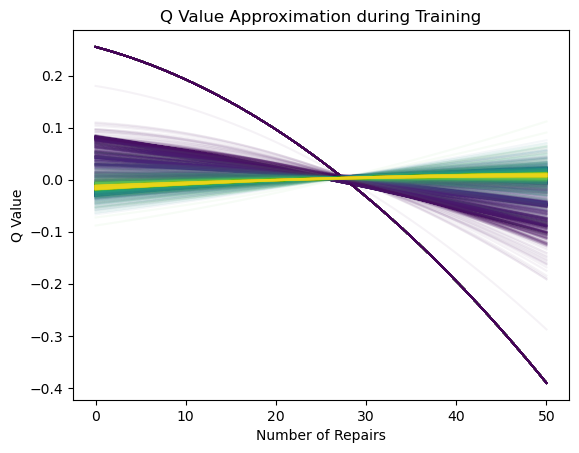

In [55]:
colors = plt.cm.viridis(np.linspace(0, 1, EPOCHS))

for i, q in enumerate(q_cache):
	if True:
		plt.plot(q - q.mean(), alpha = 0.05, color = colors[i])

plt.xlabel("Number of Repairs")
plt.ylabel("Q Value")
plt.title("Q Value Approximation during Training")
plt.show()

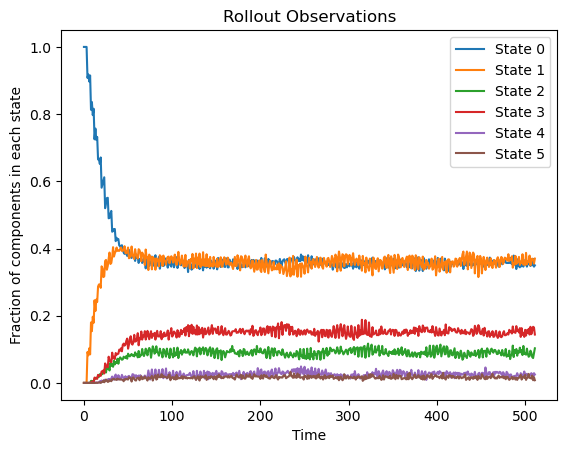

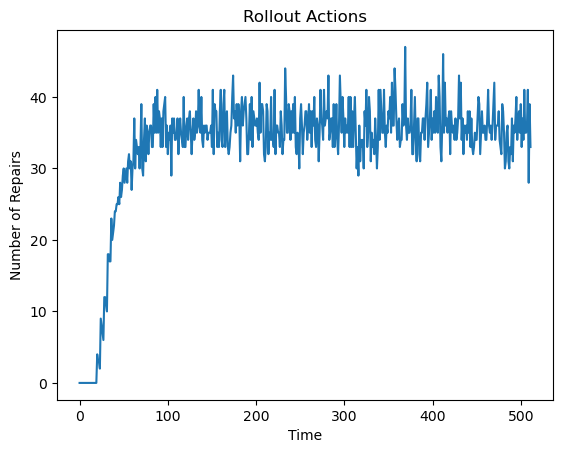

In [60]:
rollout = dqt_DQAK.rollout()

rollout_states = rollout[:,0]["observation"]#.reshape(4 * EPISODE_LENGTH, N_CONDITION_STATES)
rollout_actions = rollout[:,0]["action"]#.reshape(4 * EPISODE_LENGTH,N_COMPONENTS)
rollout_actions = torch.sum(rollout_actions, dim=1)

plt.plot( rollout_states.cpu().numpy())
plt.xlabel("Time")
plt.ylabel("Fraction of components in each state")
plt.legend([f"State {i}" for i in range(N_CONDITION_STATES)])
plt.title("Rollout Observations")
plt.show()

plt.plot(rollout_actions.cpu().numpy())
plt.xlabel("Time")
plt.ylabel("Number of Repairs")
plt.title("Rollout Actions")
plt.show()

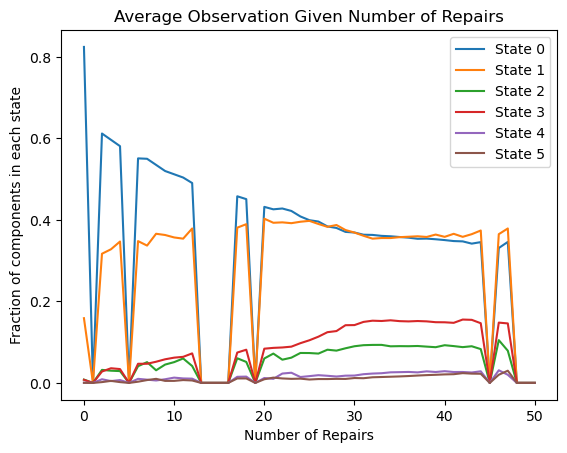

In [61]:
average_observation_when_reward_given = torch.zeros((MAX_REPAIR_CONSTRAINT+1, N_CONDITION_STATES), device=device)
average_observation_when_reward_given_count = torch.zeros((MAX_REPAIR_CONSTRAINT+1, N_CONDITION_STATES), device=device)

for i in range(rollout_states.shape[0]):
	obs = rollout_states[i]
	average_observation_when_reward_given_count[rollout_actions[i]] += 1

	average_observation_when_reward_given[rollout_actions[i]]  = (average_observation_when_reward_given[rollout_actions[i]] * (average_observation_when_reward_given_count[rollout_actions[i]] - 1) + obs) / average_observation_when_reward_given_count[rollout_actions[i]]

plt.plot(average_observation_when_reward_given.cpu().numpy())
plt.xlabel("Number of Repairs")
plt.ylabel("Fraction of components in each state")
plt.legend([f"State {i}" for i in range(N_CONDITION_STATES)])
plt.title("Average Observation Given Number of Repairs")
plt.show()